Dans cette partie, nous allons afficher les éoliennes sur la carte de France

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv("eolien.csv", sep=";")

In [ ]:
df.head()

On retrouve ici l'emplacement de l'éolienne, ainsi que la longueur des pales, ce qui sont les informations qui nous intéressent dans un premier temps. 

On convertit la colonnes date_maj en date interprétable plus facilement

In [ ]:
import datetime

df.date_mise_en_service = pd.to_datetime((df.date_mise_en_service))

In [ ]:
df.head()

In [ ]:
df.count()

Il y a 7483 éoliennes dans ce tableau. 
L'autre donnée intéressante est que nous n'avons que 4331 date de mise en service soit 58% de date de mise en service. 

On convertit cela pour avoir des données exploitables par geopandas

In [ ]:
!pip install pandas fiona shapely pyproj rtree # à faire obligatoirement en premier pour utiliser rtree ou pygeos pour les jointures spatiales
!pip install contextily
!pip install geopandas

In [ ]:
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
!pip install --upgrade botocore==1.23.26  #Sur colab, sinon bug

In [ ]:
from shapely.geometry import Point
geometrie = [Point(xy) for xy in zip(df.x_aerogenerateur,df.y_aerogenerateur)] # colonnes du DataFrame résultants
caract_eoliennes = gpd.GeoDataFrame(df,geometry=geometrie)
caract_eoliennes = caract_eoliennes.set_crs(2154, allow_override=True)

In [162]:
caract_eoliennes.head()

,id_aerogenerateur,id_parc,code_insee,nom_commune,code_dept,code_reg,puissance,hauteur_totale,hauteur_mat_nacelle,diametre_rotor,...,date_mise_en_service,constructeur,reference_modele,x_aerogenerateur,y_aerogenerateur,epsg,libelle,date_maj,nom_eolienne,geometry
0,0005503449_E1,5503449,35068,CHATEAUBOURG,35,53,1.0,99.7,73.0,53.0,...,2011-04-23,ENERCON,E-53,371155.00,6786614.0,2154,Lambert-93,2022-05-19,NaN,POINT (-1.41971 48.09705)
1,0005306849_E1,5306849,50363,MOYON VILLAGES,50,28,2.3,124.0,83.0,82.0,...,2014-04-01,ENERCON,E-82 E2,395860.28,6887806.5,2154,Lambert-93,2022-05-31,NaN,POINT (-1.15988 49.01804)
2,0005306849_E2,5306849,50363,MOYON VILLAGES,50,28,2.3,124.0,83.0,82.0,...,2014-04-01,ENERCON,E-82 E2,395830.44,6886987.0,2154,Lambert-93,2022-05-31,NaN,POINT (-1.15970 49.01067)
3,0005306849_E3,5306849,50363,MOYON VILLAGES,50,28,2.3,124.0,83.0,82.0,...,2014-04-01,ENERCON,E-82 E2,395760.56,6886064.0,2154,Lambert-93,2022-05-31,NaN,POINT (-1.15999 49.00235)
4,0003102050_E1,3102050,16317,ST FRAIGNE,16,75,3.6,180.0,119.0,126.0,...,NaT,VESTAS,V126-3.6MW,463180.00,6547301.0,2154,Lambert-93,2022-06-22,NaN,POINT (-0.05985 45.98413)


In [ ]:
fig,ax = plt.subplots(figsize=(10, 10))
caract_eoliennes.plot(ax = ax, color = 'red', alpha = 0.2, zorder=2)

On va désormais afficher une carte de France pour afficher les éoliennes sur la carte 

On utilise le paquet Cartiflette 

In [ ]:
!pip install --upgrade urllib3==1.22.0 #Sur colab, sinon bug
!pip install py7zr #Sur colab, sinon bug
!pip install s3fs #Sur colab, sinon bug
!git clone https://github.com/InseeFrLab/cartogether.git
%cd ./cartogether
!pip install -r requirements.txt
!pip install .

In [ ]:
from cartiflette.download import get_vectorfile_ign

In [ ]:
france = get_vectorfile_ign(
    field="metropole",
    level="REGION",
    year=2022)

In [ ]:
france = france[0:13] #On retire les outre-mers de la carte
france.head()

In [ ]:
ax = france.plot()
ax.set_axis_off()

Désormais, nous allons rajouter les éoliennes sur notre carte de France

In [ ]:
fig,ax = plt.subplots(figsize=(10, 10))
caract_eoliennes.plot(ax = ax, color = 'red', alpha = 0.2, zorder=2)
france.to_crs(2154).plot(ax = ax, zorder=1, edgecolor = "black")

On rajoute de l'interactivité

In [ ]:
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Voici toutes les éoliennes pour lesquelles nous ne possédons pas les dates d'installations (3152 éoliennes soit 42% des éoliennes que nous avons affiché jusqu'ici) :

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
france.to_crs(2154).plot(ax = ax, zorder=1, edgecolor = "black")
caract_eoliennes[caract_eoliennes.date_mise_en_service.isna()].plot(ax = ax, color = 'red', alpha = 0.2, zorder=2)

Pour celles dont nous connaissons la date, nous affichons ici l'évolution du parc d'éolienne en fonction du temps

In [ ]:
periode = pd.Series(pd.date_range("2010", freq="Y", periods=14))


from ipywidgets import interact

def signal_plot(annee):
    fig, ax = plt.subplots(figsize=(10,10))
    france.to_crs(2154).plot(ax = ax, zorder=1, edgecolor = "black")
    # Plot les éoliennes
    caract_eoliennes[caract_eoliennes.date_mise_en_service < annee].plot(ax = ax, color = 'red', alpha = 0.2, zorder=2)   
    
interact(signal_plot,
            annee=periode)

En affichant celle dont on ne connait pas date d'installation en vert on n'obtient ce graphique :

In [ ]:
periode = pd.Series(pd.date_range("2010", freq="Y", periods=14))



from ipywidgets import interact


def signal_plot(annee):
    fig, ax = plt.subplots(figsize=(10,10))
    france.to_crs(2154).plot(ax = ax, zorder=1, edgecolor = "black")
    # Plot les éoliennes
    caract_eoliennes[caract_eoliennes.date_mise_en_service.isna()].plot(ax = ax, color = 'green', alpha = 0.2, zorder=2)  
    caract_eoliennes[caract_eoliennes.date_mise_en_service < annee].plot(ax = ax, color = 'red', alpha = 0.2, zorder=2)  

interact(signal_plot,
            annee=periode)

Tentative de récupération des données de ventTentative de récupération des données météo via OpenWeatherMap

In [ ]:
import json
import requests

Exemple d'utilisation de l'api pour récupérer les données de vent à une latitude/longitude donnée à une date donnée

In [ ]:
base_url = "https://api.open-meteo.com/v1/meteofrance?"
latitude=str(52.52)
longitude=str(13.41)
start_date="2022-06-08"
end_date="2022-12-04"
complete_url = base_url + "latitude=" + latitude + "&longitude=" + longitude + "&hourly=windspeed_10m&windspeed_unit=ms&start_date="+start_date+"&end_date="+end_date

reponse = requests.get(complete_url)
print(reponse.content)

In [148]:
base_url = "https://archive-api.open-meteo.com/v1/era5?"
latitude=str(52.52)
longitude=str(13.41)
start_date="2022-06-08"
end_date="2012-12-04"
complete_url = base_url + "latitude=" + latitude + "&longitude=" + longitude + "&hourly=windspeed_10m&windspeed_unit=ms&start_date="+start_date+"&end_date="+end_date

reponse = requests.get(complete_url)
#print(reponse.content)

On va essayer de récupérer le vent pour une éolienne, par exemple la prémière de notre ligne 

In [149]:
caract_eoliennes = caract_eoliennes.to_crs(4326)

In [150]:
a = caract_eoliennes.geometry[0]
print(a)
print(a.x)

POINT (-1.4197135477946279 48.09705051237692)
-1.4197135477946279


In [165]:
latitude=str(a.y)
longitude=str(a.x)
start_date=str(pd.to_datetime(caract_eoliennes.date_mise_en_service[0]).date())
print(start_date)
end_date="2022-12-04"

2011-04-23


In [166]:
complete_url = base_url + "latitude=" + latitude + "&longitude=" + longitude + "&hourly=windspeed_10m&windspeed_unit=ms&start_date="+start_date+"&end_date="+end_date


import json
json.rep = requests.get(complete_url).json()

In [238]:
donnees_vent = pd.DataFrame(json.rep['hourly'])

donnees_vent['time'] = pd.to_datetime(donnees_vent['time'])
donnees_vent = donnees_vent.set_index('time')

donnees_vent.head()

,windspeed_10m
time,
2011-04-23 00:00:00,2.34
2011-04-23 01:00:00,2.33
2011-04-23 02:00:00,1.80
2011-04-23 03:00:00,1.84
2011-04-23 04:00:00,1.70


On trace le graph du vent en fonction du temps pour cette éolienne

<AxesSubplot: xlabel='time'>

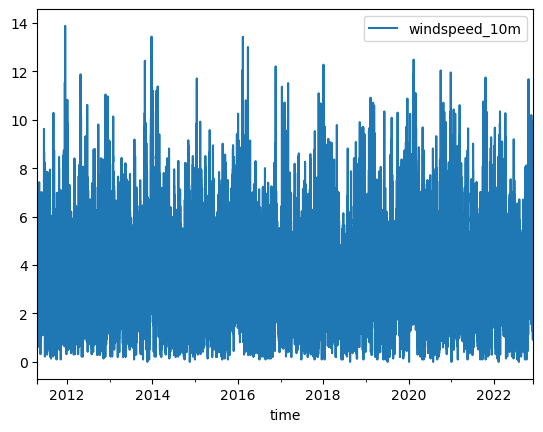

In [239]:
donnees_vent.plot()

Ici, on affiche les moyennes de vent par an et par mois

<AxesSubplot: xlabel='time'>

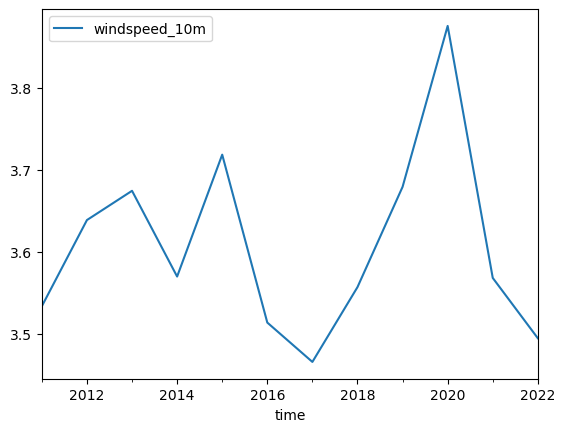

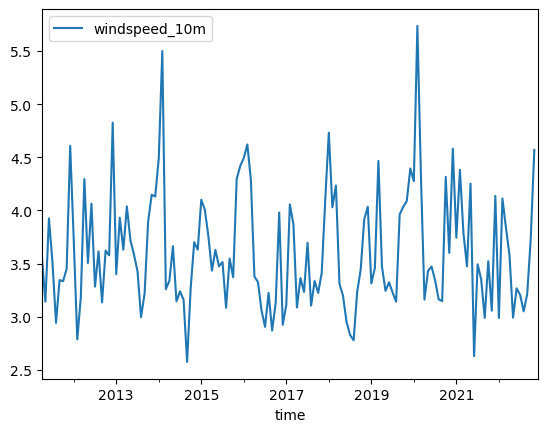

In [244]:
donnees_vent.resample('Y').mean().plot()
donnees_vent.resample('M').mean().plot()


La puissance d'une éolienne est donnée par $P = 1/2 \rho S V^3$ où $V$ est la vitesse du vent et $S = \pi/4 d^2$ est la surface de brassage de l'éolienne avec $d$ le diamètre du rotor. 
Nous avons accès dans nos données à la longueur des pâles des éoliennes donc nous pouvons retrouver la puissance de l'éolienne.
L'énergie fournie sur une heure est donc cette puissance multiplié par le temps. Pour une éolienne, on peut considérer un facteur de charge de 16/27 (limite de Betz). Nous allons le prendre en compte pour calculer l'énergie fourni par une éolienne. 
Nous pourrions aller plus loin en prenant en compte la température et la pression qui influent sur la masse volumique de l'air $\rho$ et peuvent conduire à une variation de l'ordre de 20%.
Un truc intéressant à regarder serait la moyenne du vent par mois.

In [249]:
rho_air = 1.2

def calcul_energie(diametre_rotor,vitesse_vent):
    return 16/27/2 * rho_air * np.pi/4 * longueur_pale**2 * np.power(vitesse_vent,3)

In [250]:
diametre_rotor = caract_eoliennes['diametre_rotor'][0]

In [251]:
donnees_vent['energie'] = calcul_energie(diametre_rotor,donnees_vent['windspeed_10m'])

<AxesSubplot: xlabel='time'>

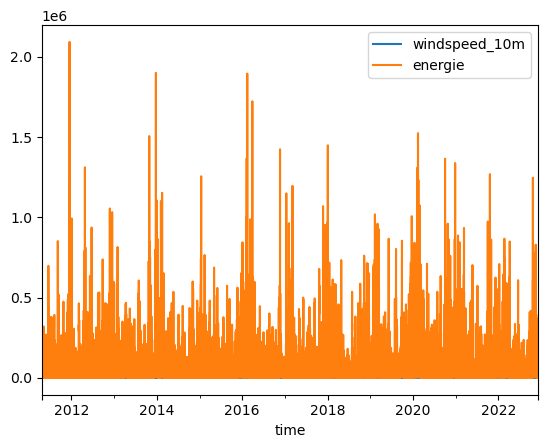

In [252]:
donnees_vent.plot()

Moyenne d'énergie sur le mois 

<AxesSubplot: xlabel='time'>

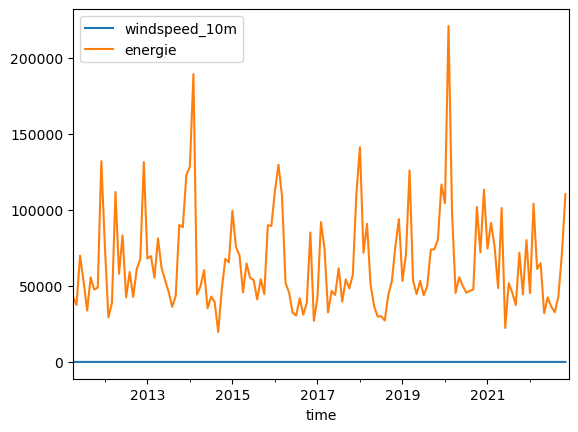

In [253]:
donnees_vent.resample('M').mean().plot()

Désormais, nous allons réaliser ces étapes pour chacune de nos éoliennes

In [220]:
for eolienne in caract_eoliennes['id']:
    print(eolienne)

KeyError: 'id'